# Predict Contraceptive Method Choice from  Demographic and Socio-Economic Characteristics

In the workshop for this week, you are to select a data set from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html) and based on the recommended analysis type, wrangle the data into a fitted model, showing some model evaluation. In particular:

- Layout the data into a dataset X and targets y.
- Choose regression, classification, or clustering and build the best model you can from it. 
- Report an evaluation of the model built
- Visualize aspects of your model (optional)
- Compare and contrast different model families

When complete, I will review your code, so please submit your code via pull-request to the [Introduction to Machine Learning with Scikit-Learn](https://github.com/georgetown-analytics/machine-learning) repository!

## Contraceptive Method Choice Data Set

Downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice) on April 16, 2016. The first thing is to fully describe your data in a README file. The dataset description is as follows:

- Data Set: Multivariate
- Tasks: Classification
- Instances: 1473
- Attributes: 9

### Data Set Information:

This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

The data set can be used for the tasks of classification.

### Attribute Information:

1. Wife's age (numerical) 
2. Wife's education (categorical) 1=low, 2, 3, 4=high 
3. Husband's education (categorical) 1=low, 2, 3, 4=high 
4. Number of children ever born (numerical) 
5. Wife's religion (binary) 0=Non-Islam, 1=Islam 
6. Wife's now working? (binary) 0=Yes, 1=No 
7. Husband's occupation (categorical) 1, 2, 3, 4 
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
9. Media exposure (binary) 0=Good, 1=Not good 
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

### Relevant Papers:

Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of Prediction Accuracy, Complexity, and Training Time of Thirty-three Old and New Classification Algorithms. Machine Learning. ([Web Link] or [Web Link]) 
[Web Link] 

## Data Exploration 

In this section we will begin to explore the dataset to determine relevant information.

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data"

def fetch_data(fname='cmc.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'w') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [3]:
FEATURES  = [
    "wife_age", 
    "wife_education", 
    "husband_education", 
    "number_births", 
    "wife_religion", 
    "wife_working", 
    "husband_occupation",
    "sol_living", 
    "media_exposure",
    "method_used"
    ]

LABEL_MAP = {
    1: "No-use", 
    2: "Long-term",
    3: "Short-term",
}

# Read the data into a DataFrame
df = pd.read_csv(DATA, sep=',', header=None, names=FEATURES)

#Convert class labels into text
for k,v in LABEL_MAP.items():
    df.ix[df.method_used == k, 'method_used'] = v

# Describe the dataset
print df.head()
print df.describe()

   wife_age  wife_education  husband_education  number_births  wife_religion  \
0        24               2                  3              3              1   
1        45               1                  3             10              1   
2        43               2                  3              7              1   
3        42               3                  2              9              1   
4        36               3                  3              8              1   

   wife_working  husband_occupation  sol_living  media_exposure method_used  
0             1                   2           3               0      No-use  
1             1                   3           4               0      No-use  
2             1                   3           4               0      No-use  
3             1                   3           3               0      No-use  
4             1                   3           2               0      No-use  
          wife_age  wife_education  husband_educati

In [4]:
# Determine the shape of the data
print "{} instances with {} features\n".format(*df.shape)

# Determine the frequency of each class
print df.groupby('method_used')['method_used'].count()

1473 instances with 10 features

method_used
Long-term     333
No-use        629
Short-term    511
Name: method_used, dtype: int64


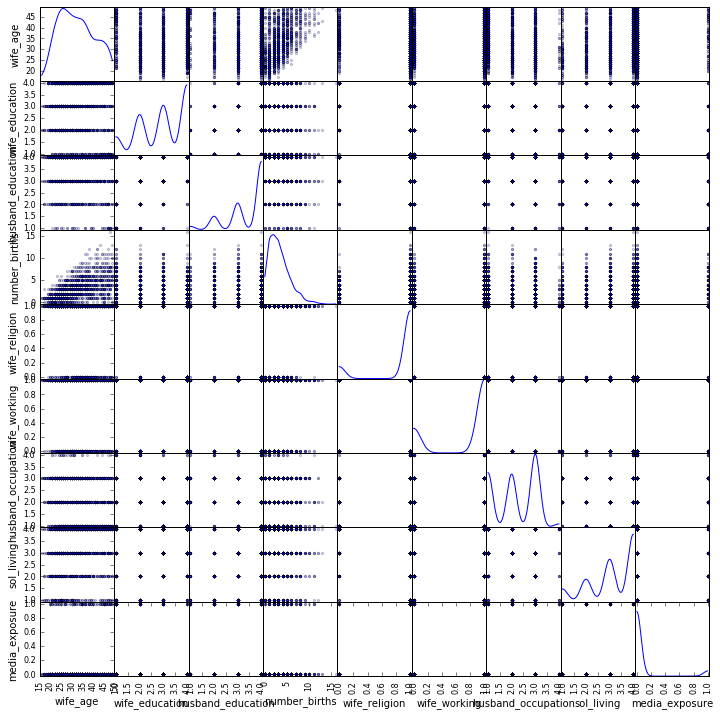

In [5]:
# Create a scatter matrix of the dataframe features
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

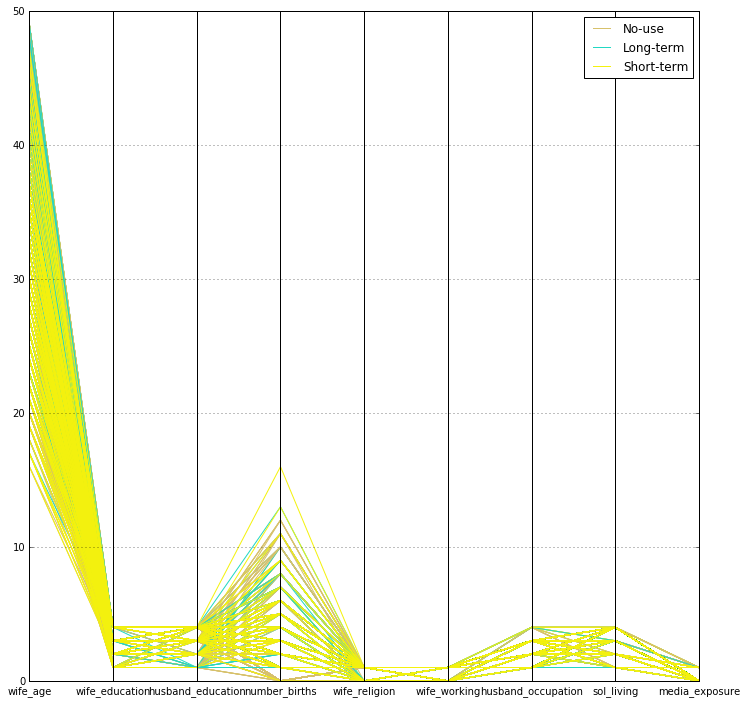

In [6]:
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(12,12))
parallel_coordinates(df, 'method_used')
plt.show()

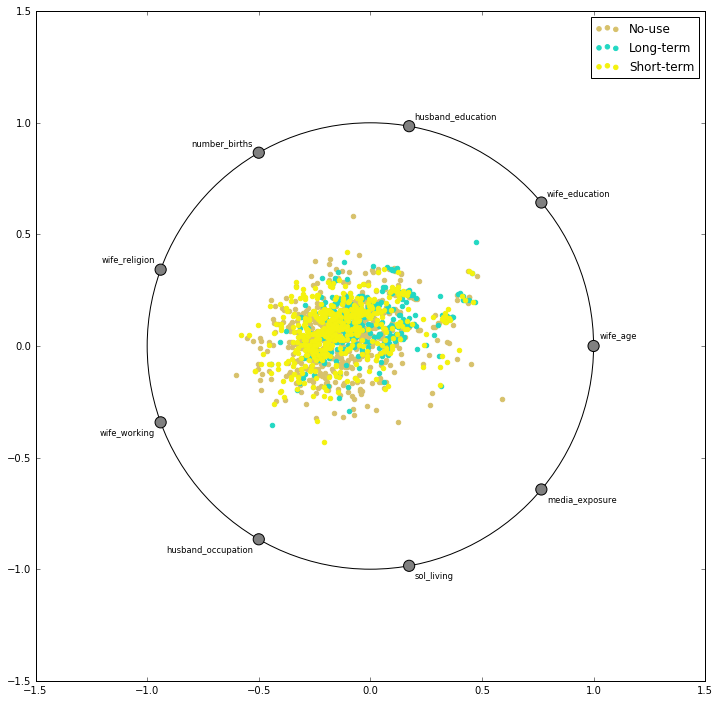

In [7]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(12,12))
radviz(df, 'method_used')
plt.show()

## Data Extraction 

One way that we can structure our data for easy management is to save files on disk. The Scikit-Learn datasets are already structured this way, and when loaded into a `Bunch` (a class imported from the `datasets` module of Scikit-Learn) we can expose a data API that is very familiar to how we've trained on our toy datasets in the past. A `Bunch` object exposes some important properties:

- **data**: array of shape `n_samples` * `n_features`
- **target**: array of length `n_samples`
- **feature_names**: names of the features
- **target_names**: names of the targets
- **filenames**: names of the files that were loaded
- **DESCR**: contents of the readme

**Note**: This does not preclude database storage of the data, in fact - a database can be easily extended to load the same `Bunch` API. Simply store the README and features in a dataset description table and load it from there. The filenames property will be redundant, but you could store a SQL statement that shows the data load. 

In order to manage our data set _on disk_, we'll structure our data as follows:

In [8]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.path.abspath(os.path.join(".", "..","data", "contraception"))

# Show the contents of the data directory
for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print "- {}".format(name)

- cmc.txt
- dataset.csv
- meta.json
- README.MD
- wrangle.py


In [9]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'cmc.txt'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.loadtxt(filenames['data'], delimiter=',')

    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print dataset.data.shape
print dataset.target.shape

(1473, 9)
(1473,)


## Classification 

Now that we have a dataset `Bunch` loaded and ready, we can begin the classification process. Let's attempt to build a classifier with kNN, SVM, and Random Forest classifiers. 

In [10]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [11]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print "Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start)
    print "Validation scores are as follows:\n"
    print pd.DataFrame(scores).mean()
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'w') as f:
        pickle.dump(estimator, f)

    print "\nFitted model written to:\n{}".format(os.path.abspath(outpath))

In [12]:
# Perform SVC Classification
fit_and_evaluate(dataset, SVC, "Contraception Method Classifier")

Build and Validation of Contraception Method Classifier took 0.967 seconds
Validation scores are as follows:

accuracy     0.565485
f1           0.562226
precision    0.571920
recall       0.565485
dtype: float64

Fitted model written to:
/Users/nicole/Desktop/GU/machine_learning_repo/machine-learning/notebook/contraception-method-classifier.pickle


In [13]:
# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Contraception Method kNN Classifier", n_neighbors=12)

Build and Validation of Contraception Method kNN Classifier took 0.043 seconds
Validation scores are as follows:

accuracy     0.539690
f1           0.536154
precision    0.539919
recall       0.539690
dtype: float64

Fitted model written to:
/Users/nicole/Desktop/GU/machine_learning_repo/machine-learning/notebook/contraception-method-knn-classifier.pickle


In [14]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Contraception Method Random Forest Classifier")

Build and Validation of Contraception Method Random Forest Classifier took 0.375 seconds
Validation scores are as follows:

accuracy     0.503721
f1           0.498601
precision    0.502968
recall       0.503721
dtype: float64

Fitted model written to:
/Users/nicole/Desktop/GU/machine_learning_repo/machine-learning/notebook/contraception-method-random-forest-classifier.pickle
